In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Convert MNIST Image file into Tensor of 4-Dimensions (No. of Images, Height, Width, and Color Channels)
transform = transforms.ToTensor()

In [ ]:
# Traning Data
train_data = datasets.MNIST(root='/CNNdata', train = True, download = True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.05MB/s]


In [ ]:
# Test Data
test_data = datasets.MNIST(root='/CNNdata', train = False, download = True, transform=transform)

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /CNNdata
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /CNNdata
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
# Create a batch size for images.
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [ ]:
# Define the CNN Model
# Description of Convolutional layer and what's happenening.

conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 36, 3, 1)


In [ ]:
# Grab 1 MNIST record/image

for i, (X_train, y_train) in enumerate(train_data):
  break
X_train.shape

torch.Size([1, 28, 28])

In [ ]:
x = X_train.view(1, 1, 28, 28)

In [ ]:
# Perform our first convolution.
x = F.relu(conv1(x)) # Rectified Linear Unit for activation function

In [ ]:
# 1 single image, 6 is the filters, 26x26 is our image size.
x.shape

torch.Size([1, 6, 26, 26])

In [ ]:
# Pooling Layer

x = F.max_pool2d(x, 2, 2) # Kernal of 2 and stride of 2

In [ ]:
x.shape # We are losing information as we're pooling.

torch.Size([1, 6, 13, 13])

In [ ]:
# Second Convolutional layer
x = F.relu(conv2(x))

In [ ]:
x.shape # Lost 2 pixel around the image as we didn't set the padding.

torch.Size([1, 36, 11, 11])

In [ ]:
# Pooling Layer 2
x = F.max_pool2d(x, 2, 2)

In [ ]:
x.shape #11 / 2 = 5.5. We round down, because we can't invent data to round up as we've lost it during pooling.

torch.Size([1, 36, 5, 5])

In [ ]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 36, 3, 1)

    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*36, 140)
    self.fc2 = nn.Linear(140, 84)
    self.fc3 = nn.Linear(84, 10)

   # Forward Function
  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # 2 x 2 Kernal and stride of 2

    # Second Pass through
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Review to flatten the data
    X = X.view(-1, 36*5*5) # Negative 1 so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)


In [ ]:
# Create an Instance of our Model

torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 36, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=900, out_features=140, bias=True)
  (fc2): Linear(in_features=140, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # Smaller the learning Rate, longer it will take to train the model.


In [ ]:
import time
start_time = time.time()

# Create Variables to Track
epochs = 6
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For Loops of Epochs
for i in range(epochs):
  trn_corr = 0 # Traning correct
  tst_corr = 0 # Testing correct

  # Train
  for b,(X_train, y_train) in enumerate(train_loader): # Changed train_data to train_loader
    b+=1 # Starts our batches at 1
    y_pred = model(X_train) # Get predicted values from the traning set. (It's not flattened.)
    loss = criterion(y_pred, y_train) # Compare the predictions to correct answers in Y-Train

    predicted = torch.max(y_pred.data, 1)[1] # Add the number of correct predictions. Indexed off the first prediction
    batch_corr = (predicted == y_train).sum() # How many were correct in this batch, True = 1, False = 0, sum them up. Added parenthesis to .sum()
    trn_corr += batch_corr # Keep track along in Traning


  # Update the parameters
    optimizer.zero_grad() # Corrected typo: zer_grad() to zero_grad()
    loss.backward()
    optimizer.step()


  # Print out the results
    if b%600 == 0:
      print(f"Epoch: {i} Batch: {b} Loss: {loss.item()}")


  train_losses.append(loss.item()) # Appended loss.item() to store the scalar value
  train_correct.append(trn_corr.item()) # Appended trn_corr.item() to store the scalar value

  # Test
  with torch.no_grad(): # No gradient so we don't update our weights and bias with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1) [1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum()


  test_losses.append(loss.item()) # Appended loss.item()
  test_correct.append(tst_corr.item()) # Appended tst_corr.item()

current_time = time.time()
total_time = current_time - start_time
print(f"Training Took: {total_time/60} minutes.")

Epoch: 0 Batch: 600 Loss: 0.21322229504585266
Epoch: 0 Batch: 1200 Loss: 0.9888861775398254
Epoch: 0 Batch: 1800 Loss: 0.04591509699821472
Epoch: 0 Batch: 2400 Loss: 0.03637535497546196
Epoch: 0 Batch: 3000 Loss: 0.1843460500240326
Epoch: 0 Batch: 3600 Loss: 0.010955842211842537
Epoch: 0 Batch: 4200 Loss: 0.003709843847900629
Epoch: 0 Batch: 4800 Loss: 0.02175944484770298
Epoch: 0 Batch: 5400 Loss: 0.25612589716911316
Epoch: 0 Batch: 6000 Loss: 0.016423944383859634
Epoch: 1 Batch: 600 Loss: 0.01805949956178665
Epoch: 1 Batch: 1200 Loss: 0.0014996161917224526
Epoch: 1 Batch: 1800 Loss: 0.23141202330589294
Epoch: 1 Batch: 2400 Loss: 0.09703756868839264
Epoch: 1 Batch: 3000 Loss: 0.0039405254647135735
Epoch: 1 Batch: 3600 Loss: 0.0004530980659183115
Epoch: 1 Batch: 4200 Loss: 0.0033523202873766422
Epoch: 1 Batch: 4800 Loss: 0.048272691667079926
Epoch: 1 Batch: 5400 Loss: 0.14222970604896545
Epoch: 1 Batch: 6000 Loss: 0.01695280708372593
Epoch: 2 Batch: 600 Loss: 0.11497227847576141
Epoch:

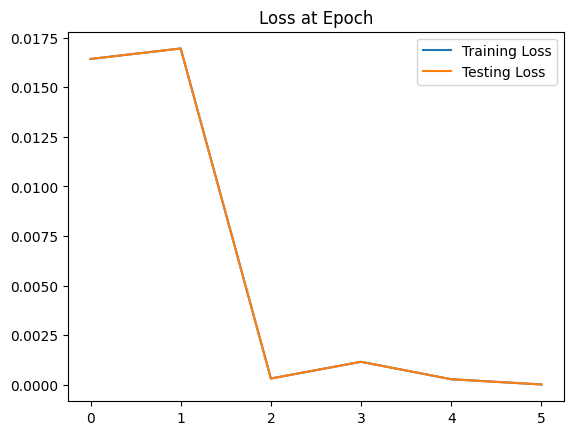

In [ ]:
# Graph the loss at epoch
# train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses, label = "Testing Loss")
plt.title("Loss at Epoch")
plt.legend()

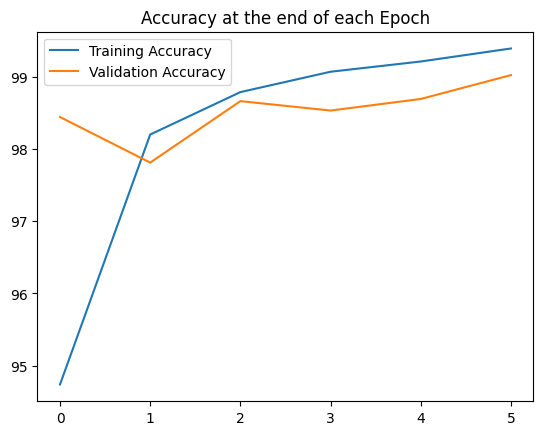

In [ ]:
# Graph the Accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/100 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [ ]:
test_load_everything = DataLoader(test_data, batch_size = 10000, shuffle = False)
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

In [ ]:
# Accuracy Percentage
correct.item()/len(test_data) * 100


99.02